In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import glob
import re
import openpyxl
import math
from matplotlib import pyplot as plt
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.optimize import minimize
import seaborn as sns

# Data

In [16]:
sofr_idx = pd.read_excel('./data/longterm_index.xlsx')
sofr_idx['Effective Date'] = pd.to_datetime(sofr_idx['Effective Date'])
sofr_idx = sofr_idx.sort_values('Effective Date')
sofr_idx

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Effective Date,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions),Target Rate From (%),Target Rate To (%),Intra Day - Low (%),Intra Day - High (%),Standard Deviation (%),30-Day Average SOFR,90-Day Average SOFR,180-Day Average SOFR,SOFR Index,Revision Indicator (Y/N),Footnote ID
855,2020-03-02,SOFRAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.58731,1.56063,1.71663,1.040850,NaN,NaN
854,2020-03-03,SOFRAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.58698,1.56108,1.71316,1.040896,NaN,NaN
853,2020-03-04,SOFRAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.58831,1.56220,1.70996,1.040944,NaN,NaN
852,2020-03-05,SOFRAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.57630,1.55863,1.70481,1.040979,NaN,NaN
851,2020-03-06,SOFRAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.56028,1.55383,1.69904,1.041012,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2023-07-27,SOFRAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.06968,5.07150,4.89957,1.089406,NaN,NaN
3,2023-07-28,SOFRAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.07838,5.07714,4.90532,1.089567,NaN,NaN
2,2023-07-31,SOFRAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.10145,5.09366,4.92232,1.090048,NaN,NaN
1,2023-08-01,SOFRAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.10884,5.09929,4.92801,1.090209,NaN,NaN


In [25]:
sofr_idx.index = sofr_idx['Effective Date']
sofr_idx['Repo'] = sofr_idx['SOFR Index'].pct_change()
# sofr_idx['SOFR Index']/sofr_idx['SOFR Index'].shift() - 1

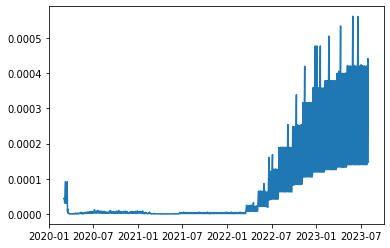

In [26]:
plt.plot(sofr_idx.index, sofr_idx['Repo'])

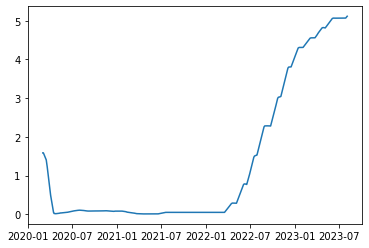

In [27]:
plt.plot(sofr_idx.index, sofr_idx['30-Day Average SOFR'])

In [22]:
sofr_rate = pd.read_excel('./data/longterm_sofr.xlsx')
sofr_rate['Effective Date'] = pd.to_datetime(sofr_rate['Effective Date'])
sofr_rate = sofr_rate.sort_values('Effective Date')
sofr_rate

,Effective Date,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions),Target Rate From (%),Target Rate To (%),Intra Day - Low (%),Intra Day - High (%),Standard Deviation (%),30-Day Average SOFR,90-Day Average SOFR,180-Day Average SOFR,SOFR Index,Revision Indicator (Y/N),Footnote ID
1332,2018-04-02,SOFR,1.80,1.25,1.77,1.89,2.25,849.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1331,2018-04-03,SOFR,1.83,1.62,1.81,1.91,2.00,825.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1330,2018-04-04,SOFR,1.74,1.65,1.70,1.79,1.84,859.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1329,2018-04-05,SOFR,1.75,1.65,1.70,1.81,1.85,829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1328,2018-04-06,SOFR,1.75,1.65,1.70,1.80,1.84,845.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2023-07-26,SOFR,5.06,5.00,5.05,5.11,5.16,1452.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-07-27,SOFR,5.31,5.07,5.30,5.37,5.42,1501.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-07-28,SOFR,5.30,5.25,5.30,5.36,5.41,1419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-07-31,SOFR,5.31,5.25,5.30,5.36,5.41,1551.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


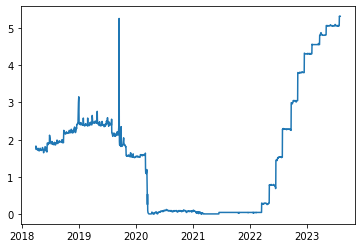

In [24]:
plt.plot(sofr_rate['Effective Date'], sofr_rate['Rate (%)'])

Text(0.5, 1.0, 'SOFR Rate(Except Jumps)')

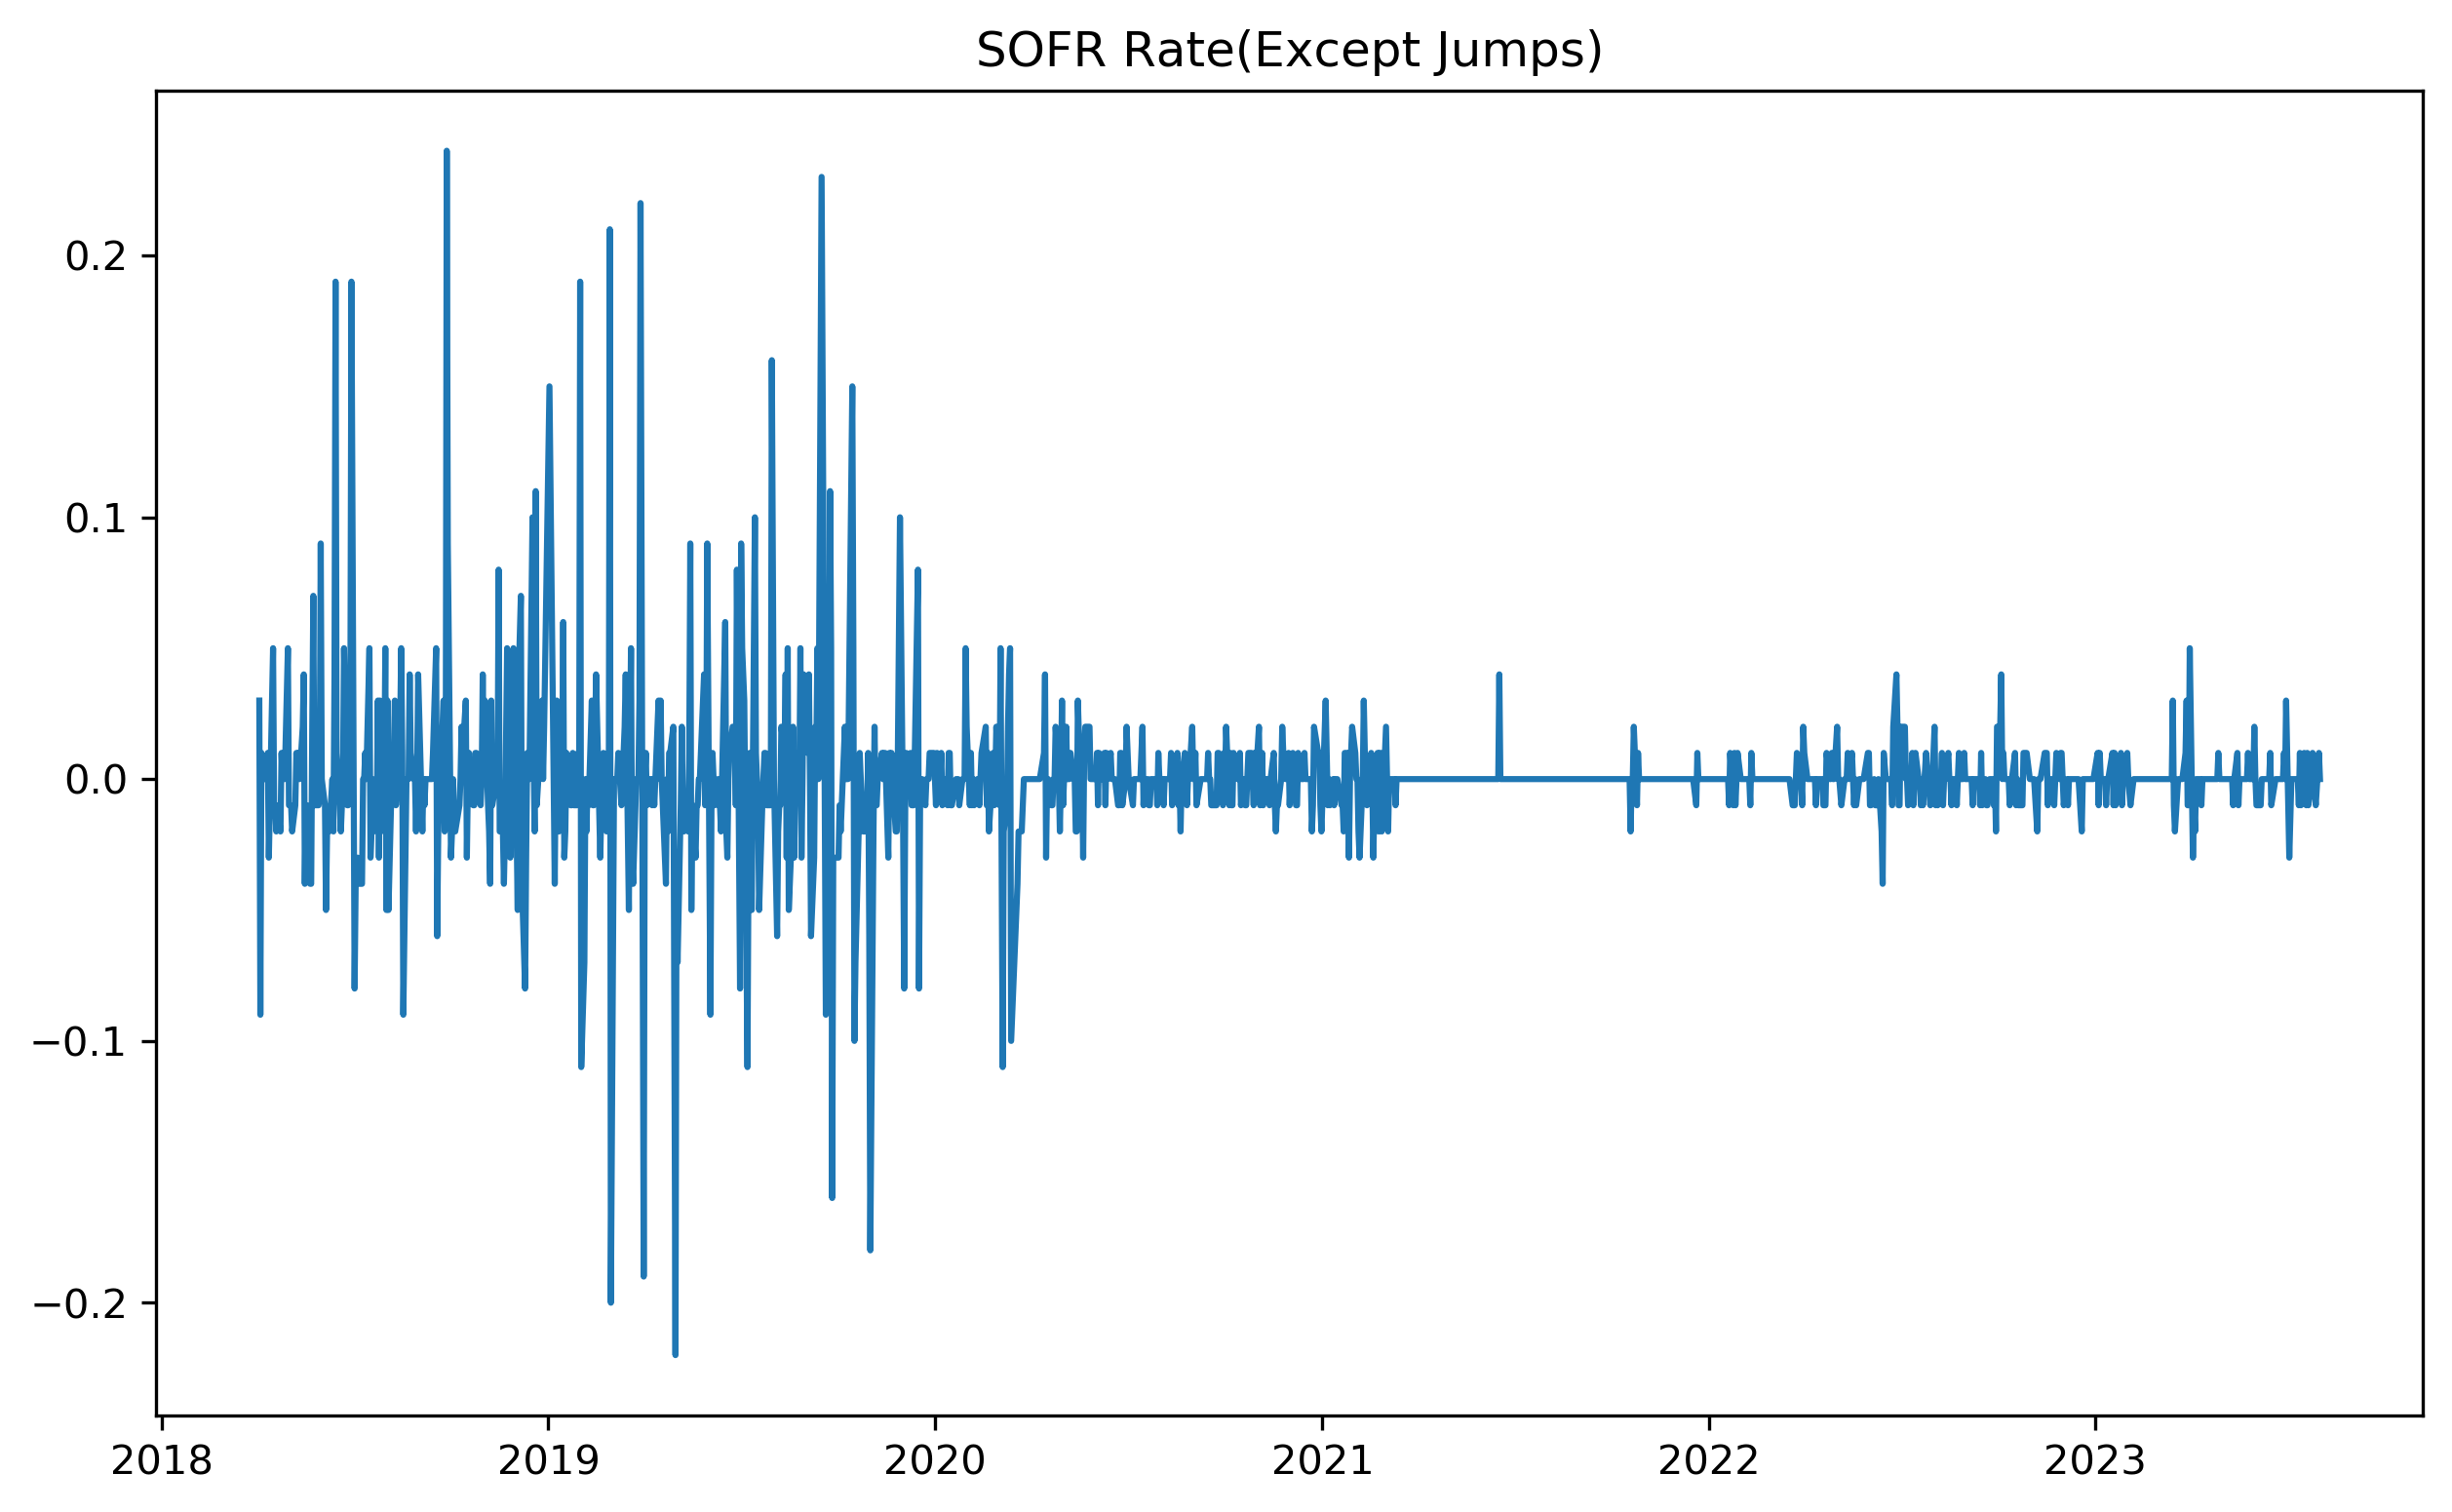

In [41]:
sofr_rate['rate_diff'] = sofr_rate['Rate (%)'].diff()
sofr_exp_jumps = sofr_rate[abs(sofr_rate['rate_diff']) < 0.25]

plt.figure(dpi=300, figsize=(10, 6))
plt.plot(sofr_exp_jumps['Effective Date'], sofr_exp_jumps['rate_diff'])
plt.title('SOFR Rate(Except Jumps)')

In [44]:
sofr_exp_jumps.index = range(len(sofr_exp_jumps))

In [45]:
sofr_exp_jumps['fake'] = sofr_exp_jumps['rate_diff'].cumsum() + sofr_exp_jumps.loc[0, 'Rate (%)']

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


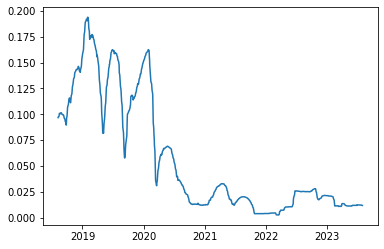

In [47]:
sofr_exp_jumps['rolling_vol_30'] = sofr_exp_jumps['fake'].rolling(90).std()
plt.plot(sofr_exp_jumps['Effective Date'], sofr_exp_jumps['rolling_vol_30'])

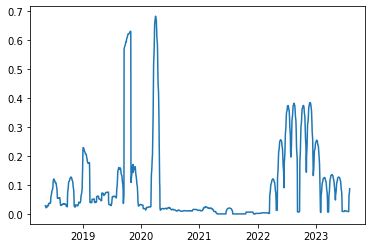

In [28]:
sofr_rate['rolling_vol_30'] = sofr_rate['Rate (%)'].rolling(30).std()
plt.plot(sofr_rate['Effective Date'], sofr_rate['rolling_vol_30'])

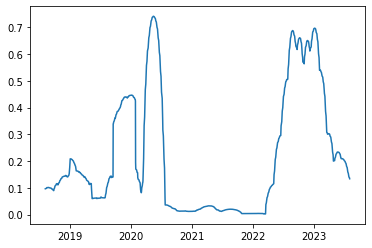

In [29]:
sofr_rate['rolling_vol_90'] = sofr_rate['Rate (%)'].rolling(90).std()
plt.plot(sofr_rate['Effective Date'], sofr_rate['rolling_vol_90'])